**Agglomerative Clustering might be good for feature selection**

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [8]:
X_train_scaled = pd.read_pickle('data/X_train_scaled.pkl')
X_test_scaled = pd.read_pickle('data/X_test_scaled.pkl')
y_train_common = pd.read_pickle('data/y_train_common.pkl')
y_train_motor = pd.read_pickle('data/y_train_motor.pkl')
y_train_total = pd.read_pickle('data/y_train_total.pkl')
y_test_common = pd.read_pickle('data/y_test_common.pkl')
y_test_motor = pd.read_pickle('data/y_test_motor.pkl')
y_test_total = pd.read_pickle('data/y_test_total.pkl')

## Feature Selection

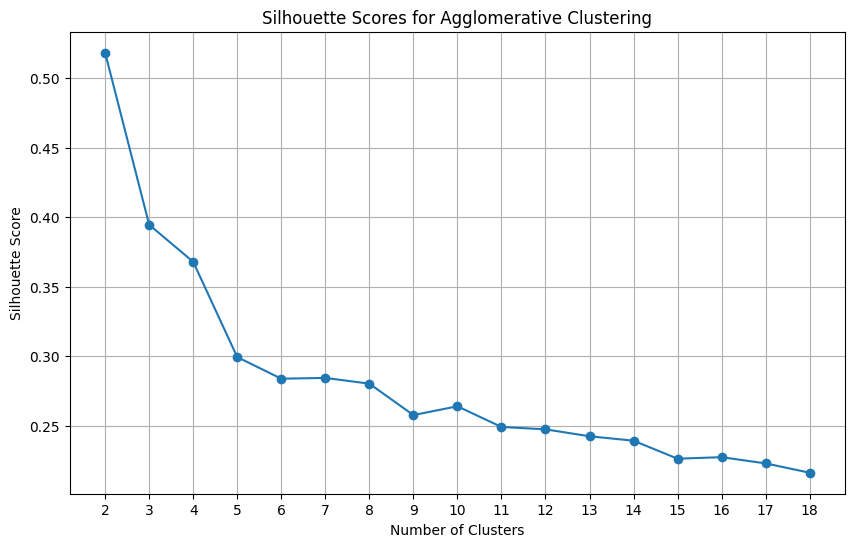

In [9]:
# do feature selection using agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Create a function to perform agglomerative clustering and calculate silhouette score
def agglomerative_clustering(X, n_clusters):
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clustering.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    return silhouette_avg

# Define the range of clusters to test
n_clusters_range = range(2, 19)
silhouette_scores = []
# Perform agglomerative clustering for each number of clusters and calculate silhouette score
for n_clusters in n_clusters_range:
    silhouette_avg = agglomerative_clustering(X_train_scaled, n_clusters)
    silhouette_scores.append(silhouette_avg)
# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Agglomerative Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(n_clusters_range)
plt.grid()

In [10]:
# simple model

## Add features

In [ ]:
# add features about mean, median, and std of the data
X_train_scaled['mean'] = X_train_scaled.mean(axis=1)
X_train_scaled['median'] = X_train_scaled.median(axis=1)
X_train_scaled['std'] = X_train_scaled.std(axis=1)
X_test_scaled['mean'] = X_test_scaled.mean(axis=1)
X_test_scaled['median'] = X_test_scaled.median(axis=1)
X_test_scaled['std'] = X_test_scaled.std(axis=1)